# Time Series Analysis

## Introduction

A time series is simply the observation of a random variable $\{x_t\}$ over a sample time frame, $t=1,...,T$.  Examples include financial data, temperature data, the luminosity of lights in an NYC apartment througout the evening, or the ambient sound on the NYC street corner throughout the day.

Time increments could be a month, a day, a second, or something smaller.

We propose that some Data Genereating Process gave rise to the observations.

Our goal is to the model a time series in order to learn about its characteristics, either for hypothesis testing or prediction.

### Key Topics in Time Series Analysis

1. Trends.  Are there consistent upward or downward patterns?
2. Serial dependence.  Are there positive or negative correlations of time-adjacent observations?
3. Stationarity.  Would the series diverge to $\pm \infty$ in finite time? 

Let's look at two time series to discuss these key topics.

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import Quandl
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

In [2]:
start_date = "2000-01-01"
end_date = "2015-10-10"
tbill3Q = Quandl.get("FRED/DTB3", trim_start=start_date, trim_end=end_date)
tbond10Q = Quandl.get("FRED/DGS10", trim_start=start_date, trim_end=end_date)

tbill3 = tbill3Q['VALUE']
tbond10 = tbond10Q['VALUE']

(0, 7)

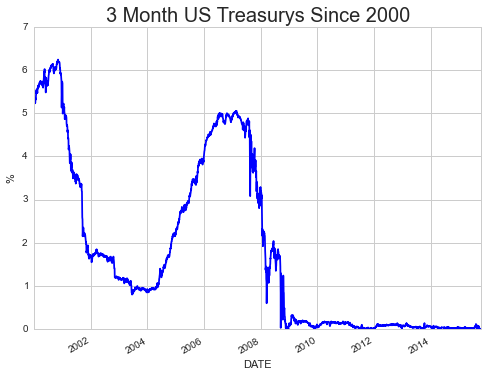

In [3]:
plt.figure(figsize = (8, 6))
tbill3.plot(color = 'blue')
plt.title('3 Month US Treasurys Since 2000', fontsize=20)
plt.ylabel('%')
plt.ylim(0,7)

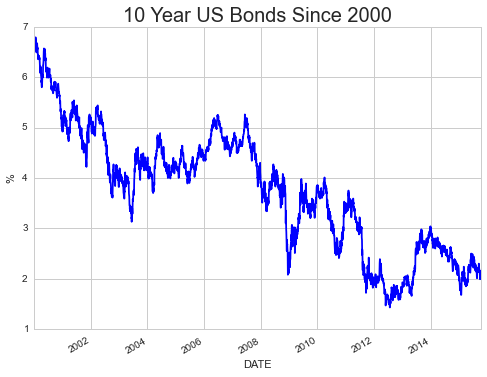

In [4]:
plt.figure(figsize = (8, 6))
tbond10.plot(color = 'blue')
plt.title('10 Year US Bonds Since 2000', fontsize=20)
plt.ylabel('%')

### How We Will Proceed

1. Start with Markov processes and how to model them.
2. Turn to formal times series models building up from white noise processes.
3. Autoregressive models of order 1, AR(1).  
4. The unit root: linking AR(1) to Markov processes.
5. Moving average models.  
6. ARMA.
7. Filtering trends and cyclicality.

## Introduction to Markov Processes

In [5]:
print("Deterministic Markov Transition Matrix")
table = [[" ", "S", "M", "T", "W", "T", "F", "S"],
         ["S", "0", "1", "0", "0", "0", "0", "0",],
         ["M", "0", "0", "1", "0", "0", "0", "0",],
         ["T", "0", "0", "0", "1", "0", "0", "0",],
         ["W", "0", "0", "0", "0", "1", "0", "0",],
         ["T", "0", "0", "0", "0", "0", "1", "0",],
         ["F", "0", "0", "0", "0", "0", "0", "1",],
         ["S", "1", "0", "0", "0", "0", "0", "0",],]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

Deterministic Markov Transition Matrix
╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│   │ S │ M │ T │ W │ T │ F │ S │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ S │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ M │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ T │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ W │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ T │ 0 │ 0 │ 0 │ 0 │ 0 │ 1 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ F │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 1 │
├───┼───┼───┼───┼───┼───┼───┼───┤
│ S │ 1 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛
()


In [6]:
print("Day of Week Vector: Today is Monday")
table = [["S", "M", "T", "W", "T", "F", "S"],
         ["0", "1", "0", "0", "0", "0", "0",]]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

Day of Week Vector: Today is Monday
╒═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ S │ M │ T │ W │ T │ F │ S │
├───┼───┼───┼───┼───┼───┼───┤
│ 0 │ 1 │ 0 │ 0 │ 0 │ 0 │ 0 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╛
()


How do we iterate the day of the week?  Today is Monday.  What is tomorrow?

day of week vector * Markov transition matrix = ? 

In [7]:
# Let's find out.

MT = np.matrix('0 1 0 0 0 0 0; 0 0 1 0 0 0 0; 0 0 0 1 0 0 0; 0 0 0 0 1 0 0; 0 0 0 0 0 1 0; 0 0 0 0 0 0 1; 1 0 0 0 0 0 0')
dow = np.matrix('0 1 0 0 0 0 0')

print("Markov Transition Matrix")
print(MT)
print()
print("Today")
print(dow)
print()
print("Tomorrow")
print (dow * MT)
print()
print("The Day After Tomorrow")
print (dow * MT * MT)
print()
print("The Day After Tomorrow Using Linear Algebra")
print (dow * np.linalg.matrix_power(MT, 2))

Markov Transition Matrix
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0]]
()
Today
[[0 1 0 0 0 0 0]]
()
Tomorrow
[[0 0 1 0 0 0 0]]
()
The Day After Tomorrow
[[0 0 0 1 0 0 0]]
()
The Day After Tomorrow Using Linear Algebra
[[0 0 0 1 0 0 0]]


Obviously, tomorrow is Tuesday, and, because tomorrow is Tuesday, the day after tomorrow is Wednesday.  So, you do this every day.  Moreover, this simple deterministic example highlights the important aspects of Markov processes (of which MCMC is a part).

1. A Markov process records movement of a state vector through time.  In this example, the state vector is the day of the week.
2. Based on the Markov process, my knowledge of tomorrow is dependent $only$ on what I know today.  It does not matter what I knew yesterday.  Using this deterministic example, I know it will be Tuesday tomorrow because I know it is Monday today.  It does not matter (and I do not need to know) that yesterday was Sunday.

In [ ]:
# This is exactly how we use a Markov matrix of transition probabilities
# to iterate a system series through time.

# The state vector at time t (the system at time t) 
# times the transition probabilities yields the probabilitistic forecast
# of the state vector in time t+1.

# How would you calculate the day after the day after tomorrow?

print (dow * MT * MT)
print (dow * np.linalg.matrix_power(MT, 2))

### Formally

A Markov process $\{x_t\}$ is a stochastic process with the property that, given the outcome of $\{x_t\}$, the outcomes of $\{x_s\}$ for $s > t$ are unaffected by the outcomes of $\{x_u\}$ for $u < t$.  Therefore, $Pr(x_t = j \big| x_{t-1} = i_{t-1}, x_{t-2} = i_{t-2}, ...) = Pr(x_t = j \big| x_{t-1} = i_{t-1})$.

Write the above as $P_{ij}$: transition probability from state i to state j.  Knowing last period’s outcome is all we need.

In [8]:
# Let's apply this to something non-deterministic using a NYC Subway rat.
# If on Track A, Pr(stays) = 1/2 and Pr(moves to B) = 1/2
# If on Track B, Pr(stays) = 1/2, Pr(move to A) = 1/4, and Pr(moves to C) = 1/4
# If on Track C, Pr(stays) = 1/2 and Pr(moves to C) = 1/2

print("A Rat in a NYC Subway Tunnel")
table = [[" ", "Track A", "Track B", "Track C"],
        ["Track A", "1/2", "1/2", "0"],
        ["Track B", "1/4", "1/2", "1/4"],
        ["Track C", "0", "1/2", "1/2"],]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

MT = np.matrix('0.5 0.5 0; 0.25 0.5 0.25; 0 0.5 0.5')
print("As an Numpy matrix")
print(MT)

A Rat in a NYC Subway Tunnel
╒═════════╤═════════╤═════════╤═════════╕
│         │ Track A │ Track B │ Track C │
├─────────┼─────────┼─────────┼─────────┤
│ Track A │ 1/2     │ 1/2     │ 0       │
├─────────┼─────────┼─────────┼─────────┤
│ Track B │ 1/4     │ 1/2     │ 1/4     │
├─────────┼─────────┼─────────┼─────────┤
│ Track C │ 0       │ 1/2     │ 1/2     │
╘═════════╧═════════╧═════════╧═════════╛
()
As an Numpy matrix
[[ 0.5   0.5   0.  ]
 [ 0.25  0.5   0.25]
 [ 0.    0.5   0.5 ]]


In [9]:
# On which track do you want to place the rat in the initial time period?

rat = np.matrix('1 0 0')

In [10]:
# Now iterate the rate through time.
# The future location of the rat is inherently probabilistic (like electrons).

for i in range(1, 21):
    print('Probability rat in on Track A, B, or C at time t + %i' % (i))
    print(rat * np.linalg.matrix_power(MT, i))
    print()

Probability rat in on Track A, B, or C at time t + 1
[[ 0.5  0.5  0. ]]
()
Probability rat in on Track A, B, or C at time t + 2
[[ 0.375  0.5    0.125]]
()
Probability rat in on Track A, B, or C at time t + 3
[[ 0.3125  0.5     0.1875]]
()
Probability rat in on Track A, B, or C at time t + 4
[[ 0.28125  0.5      0.21875]]
()
Probability rat in on Track A, B, or C at time t + 5
[[ 0.265625  0.5       0.234375]]
()
Probability rat in on Track A, B, or C at time t + 6
[[ 0.2578125  0.5        0.2421875]]
()
Probability rat in on Track A, B, or C at time t + 7
[[ 0.25390625  0.5         0.24609375]]
()
Probability rat in on Track A, B, or C at time t + 8
[[ 0.25195312  0.5         0.24804688]]
()
Probability rat in on Track A, B, or C at time t + 9
[[ 0.25097656  0.5         0.24902344]]
()
Probability rat in on Track A, B, or C at time t + 10
[[ 0.25048828  0.5         0.24951172]]
()
Probability rat in on Track A, B, or C at time t + 11
[[ 0.25024414  0.5         0.24975586]]
()
Probabil

In [11]:
# Now start the rat on Track C and iterate.

rat = np.matrix('0 0 1')
for i in range(1, 21):
    print('Probability rat in on Track A, B, or C at time t + %i' % (i))
    print(rat * np.linalg.matrix_power(MT, i))
    print()

Probability rat in on Track A, B, or C at time t + 1
[[ 0.   0.5  0.5]]
()
Probability rat in on Track A, B, or C at time t + 2
[[ 0.125  0.5    0.375]]
()
Probability rat in on Track A, B, or C at time t + 3
[[ 0.1875  0.5     0.3125]]
()
Probability rat in on Track A, B, or C at time t + 4
[[ 0.21875  0.5      0.28125]]
()
Probability rat in on Track A, B, or C at time t + 5
[[ 0.234375  0.5       0.265625]]
()
Probability rat in on Track A, B, or C at time t + 6
[[ 0.2421875  0.5        0.2578125]]
()
Probability rat in on Track A, B, or C at time t + 7
[[ 0.24609375  0.5         0.25390625]]
()
Probability rat in on Track A, B, or C at time t + 8
[[ 0.24804688  0.5         0.25195312]]
()
Probability rat in on Track A, B, or C at time t + 9
[[ 0.24902344  0.5         0.25097656]]
()
Probability rat in on Track A, B, or C at time t + 10
[[ 0.24951172  0.5         0.25048828]]
()
Probability rat in on Track A, B, or C at time t + 11
[[ 0.24975586  0.5         0.25024414]]
()
Probabil

In [ ]:
# The limiting probability distribution is obtained
# by raising the transition matrix to an arbitrarily large number.
# Asymptotically, it does not matter on which track the rat started.
# You could consider this is be a long run probabilistic forecast.
# Suppose you want to kill the rat, and you could electrify only one track.  
# Which track would you electrify?

rat = np.matrix('1 0 0')
print('Probability rat in on Track A, B, or C in the long run')
print(rat * np.linalg.matrix_power(MT, 10000))

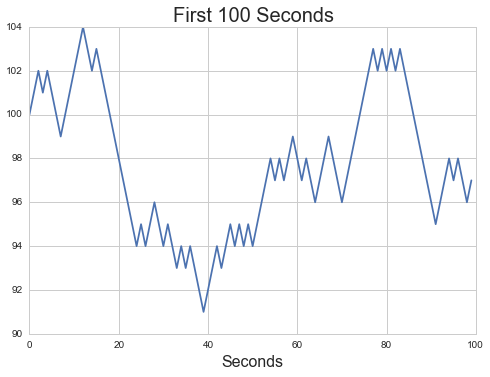

In [12]:
# Simple Application 1: A Random Walk.

# Set an arbitrary starting point and iterate the system using a simple Markov process.
# Each second, this Markov process can move up 1 or it can move down, which it does at random.
# Pr(up) = Pr(down) = 0.5.

# pos is starting position.
# draws are random integers, {0, 1}.
# step is -1 if random draw is 0 and +1 if random draw is 1.
# walk is the vector containing each step.

random.seed(1234)

pos = 100  
walk = [pos] # walk is the array that tracks the random path
nsteps = 10000 # establishs number of random steps
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 # Bernoulli draw to step "up" or "down"
    pos += step
    walk.append(pos)

plt.plot(walk[0:100])
plt.title('First 100 Seconds', fontsize=20)
plt.xlabel('Seconds', fontsize=16)

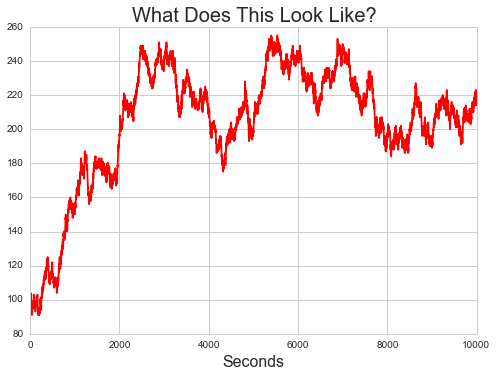

In [13]:
plt.plot(walk, 'r')
plt.title("What Does This Look Like?", fontsize=20)
plt.xlabel('Seconds', fontsize=16)

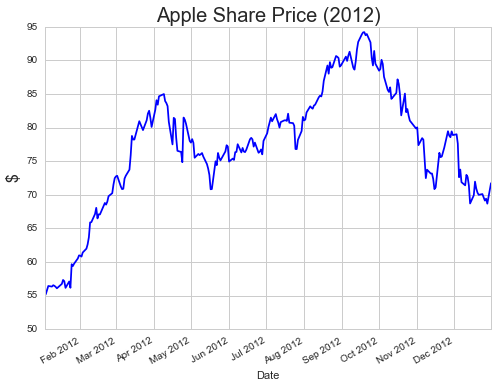

In [14]:
aapl_all = Quandl.get("YAHOO/AAPL", trim_start="2012-1-1", trim_end="2013-1-1")
aapl = aapl_all['Adjusted Close']

plt.figure(figsize = (8, 6))
aapl.plot(color = 'blue')
plt.title('Apple Share Price (2012)', fontsize=20)
plt.ylabel('$', fontsize=16)

In [15]:
# Simple Application 2: A Drunken Sailor on a Mountaintop
# A drunken sailor is dropped off at the center of a Cartesian mountain.
# The sailer stumbles forward and backward, and then to the left and to the right.
# Each stumble is random because he is drunk.

random.seed(1066)
edge = 100
nsteps = 10000

pos1, pos2 = 0, 0  
walk1, walk2 = [pos1], [pos2] 
for i in range(nsteps):
    step1 = 1 if np.random.randint(0, 2) else -1 
    step2 = 1 if np.random.randint(0, 2) else -1
    pos1 += step1
    pos2 += step2
    if np.abs(pos1) > 100 or np.abs(pos2) > 100:
        print("Sailor fell off the moutain at coordinates", pos1, pos2, "on step", i)
        break
    walk1.append(pos1)
    walk2.append(pos2)

('Sailor fell off the moutain at coordinates', 3, -101, 'on step', 6768)


(-100, 100)

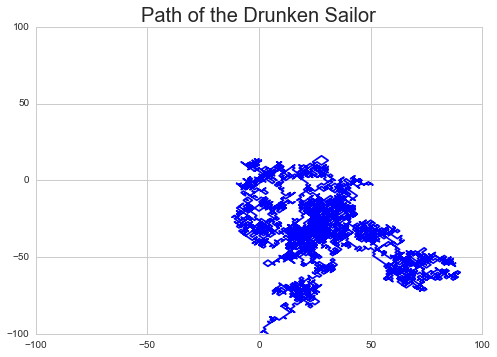

In [16]:
plt.plot(walk1, walk2, 'b')
plt.title("Path of the Drunken Sailor", fontsize=20)
plt.xlim(-edge, edge)
plt.ylim(-edge, edge)

In [17]:
nsteps = 100000

pos1, pos2, pos3 = 0, 0 , 0
walk1, walk2, walk3 = [pos1], [pos2], [pos3]
for i in range(nsteps):
    step1 = 1 if random.randint(0, 2) else -1 
    step2 = 1 if random.randint(0, 2) else -1
    step3 = 0 if random.randint(0, 2) else -1
    pos1 += step1
    pos2 += step2
    pos3 += step3

    walk1.append(pos1)
    walk2.append(pos2)
    walk3.append(pos3)

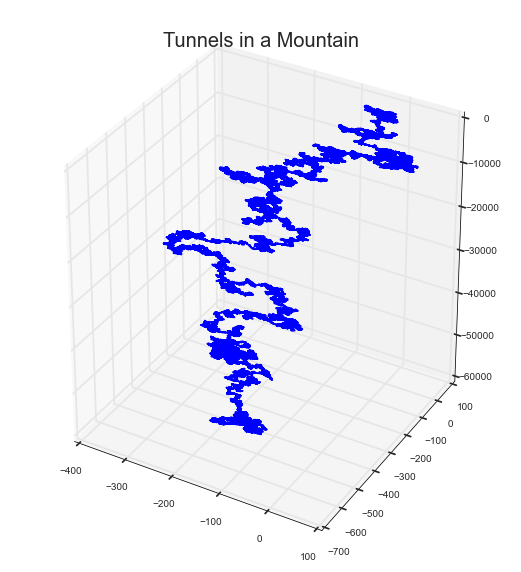

In [18]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(121, projection='3d')
ax.plot(walk1, walk2, walk3, 'b')
plt.title('Tunnels in a Mountain', fontsize=20)

### Absorbing States

Suppose there existed an absorbing state, from which a system could not escape.  How would we model this?  Think about our Subway rat.  Suppose one rail was already electrified.  If he touches it, our rat dies.

In [19]:
print("A Rat in a NYC Subway Tunnel")
table = [[" ", "Track A", "Track B", "Track C"],
        ["Track A", "1", "0", "0"],
        ["Track B", "1/4", "1/2", "1/4"],
        ["Track C", "0", "1/2", "1/2"],]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

MT = np.matrix('1 0 0; 0.25 0.5 0.25; 0 0.5 0.5')
print("As an Numpy matrix")
print(MT)

A Rat in a NYC Subway Tunnel
╒═════════╤═════════╤═════════╤═════════╕
│         │ Track A │ Track B │ Track C │
├─────────┼─────────┼─────────┼─────────┤
│ Track A │ 1       │ 0       │ 0       │
├─────────┼─────────┼─────────┼─────────┤
│ Track B │ 1/4     │ 1/2     │ 1/4     │
├─────────┼─────────┼─────────┼─────────┤
│ Track C │ 0       │ 1/2     │ 1/2     │
╘═════════╧═════════╧═════════╧═════════╛
()
As an Numpy matrix
[[ 1.    0.    0.  ]
 [ 0.25  0.5   0.25]
 [ 0.    0.5   0.5 ]]


In [20]:
# Start the rat on Track C and iterate.

rat = np.matrix('0 0 1')
print('Probability rat in on Track A, B, or C in the long run')
print(rat * np.linalg.matrix_power(MT, 10000))

Probability rat in on Track A, B, or C in the long run
[[ 1.  0.  0.]]


### Markov Chain Lab

Consider the Subway rat above.  Add two tracks to the right of Track C, labeling them Track D and Track E.  In this situation, treat Track A as an absorbing state.  If the rat is on any track other than Tracks A or E, it has probability 0.5 of remaining on that track, probability 0.25 of moving left, and probability 0.25 of moving right.  For Track E, assume probability 0.5 of remaining on that track, and probability 0.5 of moving left.  

Write out the matrix of Markov transition probabilities.  Iterate this matrix forward as many times as is necessary for you to determine empirically its limit.  Based on this limit, what can you say about the evolution of the system if the rat begins on Track C?  How about Track D?  Is there a general conclusion you can draw?

## Application: Markov Transition Probabilities of Taxi Cabs

We can use our classifiers to generate empirically-based Markov transition probabilities.  I did so to examine two things:

1. Land use in California.
2. The movement of Yellow Cabs in NYC.

Let's discuss the latter.  In any given year, there are ~180 million yellow cab journeys in New York City (NYC).  There are ~13,000 licensed yellow cabs that are in nearly-continuous daily operation.  Typically, each cab has two drivers per day who switch driving shifts around 4pm ET (frequently in Queens).  Each cab makes ~14,000 journeys/year.

In [23]:
#from PIL import Image
#import urllib2.request as url
#import io

#print("TLC's Geography of New York City")
#fd = url.urlopen("http://www.east-harlem.com/images/taximap.jpg")
#image_file = io.BytesIO(fd.read())
#Image.open(image_file) 

We want to calculate the Pr(drop-off is a particular location | pick-up is a particular location).  

How to proceed?  We need to turn a classifier into a probabilistic predictor.  Fortunately, doing so is simple.  In the taxi example, the dataframe includes the location of the pick-up and location of the drop-off (as well as many other features).  We want to calculate the Pr(drop-off is a particular location | pick-up is a particular location).  Using the TLC map, we want, for example, Pr(drop-off is Chelsea | pick-up is the Upper West Side).  This is simple: Geocode the locations according to the TLC map and use the pick-up location as a feature.  Given the size of taxi data, we are assured that multiple journeys begin in every location and end in every location.  

The problem is how to scale this effort given the massive size of the TLC data.  Unfortunately, the TLC data are too massive to use the Multinomial Logit (MNL) classifier, which is the simplest classifier to use in this situation.  

In joint CUSP discussions about scalable classifiers (highlighting the benefits of places such as CUSP), we decided to use the Random Forest algorithm.  We first selected a training set of about 500 million journeys.  We trained the classifier using a number of different features: pick-up location; time of day; day of week; number of passengers; population density; business density; weather.  (The training is exactly what we did in last Monday's class, except we did it in R.)

For the purpose of prediction, we need to obtain model-based Markov transition probabilities.  Here, we created large test dataframes using bootstrap methods with replacement for all features other than pick-up location.  For pick-up location, we drew at random integers associated with each possible location.  In other words, for the non pick-up location feature, we have representative features.  For the pick-up location, we random generated the locations.  This is precisely what we want: this is experimentation.  

Pass the test dataframes through the trained RF algorithm.  For each of the random pick-up locations (and representative features), the algorithm predicts where the cab will drop off.  Therefore,  

Pr(drop-off is Chelsea | pick-up is the Upper West Side) = 

(# of drop-offs in Chelsea having randomly started in the Upper West Side) / (# of random starts on the Upper West Side).

It is simple accounting.  Let me show you what we found.

### Slides

In [ ]:
# Let me show you a simple example of what we did.  
# Remember for sklearn, we need Numpy arrays.
# LABEL
# do is dropoff: 1 is UWS; 2 is Chelsea; 3 is UES; 4 is Midtown

# FEATURES
# pu is pickup: 1 is UWS; 2 is Chelsea; 3 is UES; 4 is Midtown
# tod is time of day based on 24-hour clock
# dow is day of week, Sunday = 0
# passengers is the number of passengers that got in the cab.

# First observation: 
# 5 passengers on Sunday morning, between 3 and 4 AM, leave the UES (a bar)
# to go to the UWS (I trust to another another bar).  

taxi = pd.read_stata("taximarkov.dta")
print(taxi.head())
ytrain = taxi['do'].as_matrix(columns=None).astype(int)
Xtrain = taxi[['pu', 'tod', 'dow', 'passengers']].as_matrix(columns=None).astype(int)
#print (ytrain[0:10])
#print (Xtrain[0:10])

In [ ]:
# Train our learners.

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100)
rf.fit(Xtrain, ytrain)

In [ ]:
# Create a prediction (in reverse order): 1 passenger on a Monday at 2pm picked up in Chelsea.
# Where does she go?
# Naive Bayes says UES.
# Random Forests says Midtown.

Xtest = [2, 14, 2, 1]
print(gnb.predict(Xtest))
Xtest = [2, 14, 2, 1]
print(rf.predict(Xtest))

Why do this?

1. It is simple to calculate naive Markov transition probabilities from the observed outcomes.  If one tried to use them for policy-making, however, one would probably not make good policy.  For example, one rationale for the outer-borough green cabs was the belief that journeys were largely borough-specific.  This belief is unfounded once one accounts for relevant features.  Many journeys begin in the outer-boroughs and end in Manhattan and the reverse is also true.    
2. For the purpose of policy-making, many journeys that begin in Queens and in Brooklyn end in Manhattan, controlling for other features.  The bridges that traverse the East River are free to passengers from the point of provision, but the tunnels are not.  It is time to tax the bridges.
3. This is a substantial methodological advancement.  We now can simulate cause and effect using the tools of ML and the existence of big data.  (For more information information on this point, see Susan Athey: https://www.youtube.com/watch?v=L72E08QsyMc)    

# White Noise Processes

Markov processes give us one way to model time series.  

We need more building blocks to develop the DGPs we think form the foundation of time series outcomes.  Let’s start with the simplest, so-called “white noise”.  Like Markov processes, white noise (WN) processes are also ubiquitous in modeling.  Eonomics and the physical sciences use Brownian motion (Wiener processes in stochastic calculus) to describe the evolution of many systems.

The definition in this context is simple: independent draws from some probability distribution with zero mean and finite variance.  We will focus on so-called “Gaussian” white noise: draws from N(0,1).  Each “period” we draw at random from N(0,1) and simply connect the dots over “time”.


## Characteristics

White noise processes arise independent draws from some probability distribution with zero mean and finite variance.  Therefore, by design, the resulting time series process:

1. Has no trend.
2. Has no serial dependence.  (Yesterday does not matter for today.  Today does not matter for tomorrow.)
3. Is stationary.

As such, it is an ideal building block.

(-6, 6)

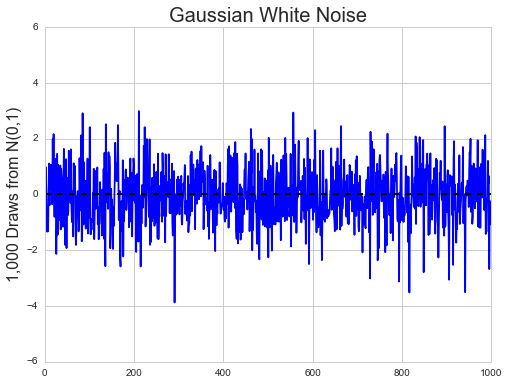

In [2]:
y = np.random.normal(0, 1, 1000)

plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Gaussian White Noise', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.ylabel('1,000 Draws from N(0,1)', fontsize=16)
plt.ylim(-6, 6)

(-6, 6)

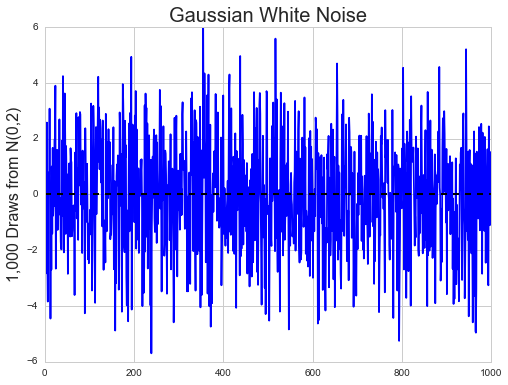

In [3]:
# Increase the variance

y = np.random.normal(0, 2, 1000)

plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Gaussian White Noise', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.ylabel('1,000 Draws from N(0,2)', fontsize=16)
plt.ylim(-6, 6)

(-6, 6)

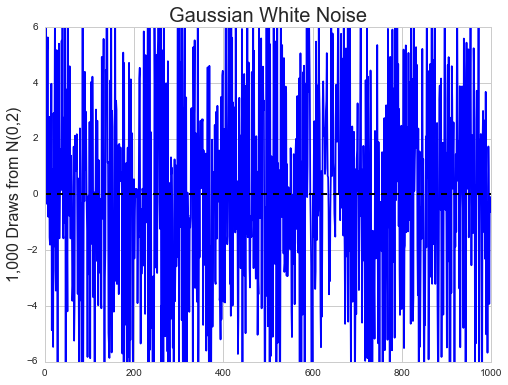

In [4]:
# And yet more

y = np.random.normal(0, 4, 1000)

plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Gaussian White Noise', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.ylabel('1,000 Draws from N(0,2)', fontsize=16)
plt.ylim(-6, 6)

Does the higher variance matter?

Increasing the variance increases the “noise” of white noise.  As long as the variance is finite, the characteristics of white noise processes remain unchanged and equally appealing.  Therefore, we will focus on white noise processes using N(0,1).
Let’s look at a simple example.

(-3, 3)

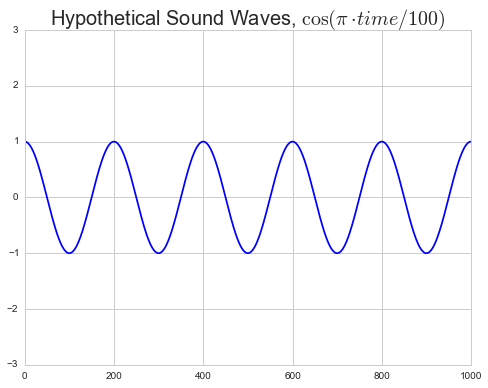

In [5]:
time = np.arange(0, 1000, 1)
y = np.cos(np.pi * time / 100)

plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Hypothetical Sound Waves, $\cos(\pi \cdot time/100)$', fontsize=20)
plt.ylim(-3, 3)

(-3, 3)

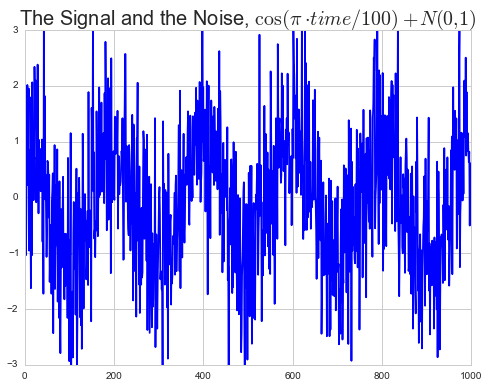

In [6]:
x = y + np.random.normal(0, 1, len(time))
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
plt.title(r'The Signal and the Noise, $\cos(\pi \cdot time/100)+N(0,1)$', fontsize=20)
plt.ylim(-3, 3)

# Autoregressive Processes of Order 1: AR(1)

We can write the AR(1) process as follows: $y_t = \rho y_{t-1} + \epsilon_t$ for $|\rho|<1$.  This process would model the rule that "Today is mostly yesterday plus a little noise."

Let's build up an AR(1) process from scratch.

$y_1 = \epsilon_1$: Take a single draw from $N(0,1)$.

Let $\rho$ denote the extent to which yesterday affects today, assuming a diminishing effect or $|\rho|<1$.

$y_2 = \rho y_1 + \epsilon_2$: Take another single draw and build up.

$y_3 = \rho y_2 + \epsilon_3$

And so on

$y_T = \rho y_T + \epsilon_T$

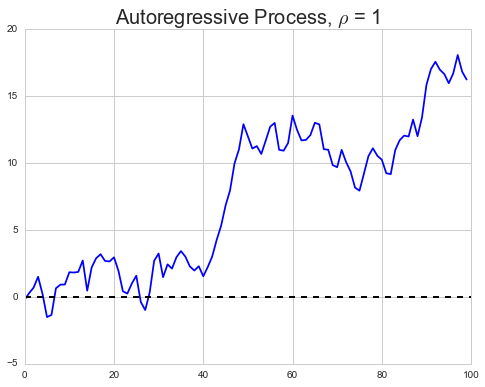

In [15]:
# Remember Python indexes from zero, so to get a sample size of 1000, set T at 999.
# Let's generate and graph, changing the value of rho to particular values.

T = 100
rho = 1
y = np.zeros(T)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)
    
# Confirm vector length
#y.shape

r = rho
plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

In [16]:
# The stationarity of the AR(1) can be derived mathematically, and we'll do a bit of that in a moment.
# But let's explore it first through MC simulation.
# The computer scientists should help me improve this code.

def Ergo(rho, T):
    
    mean = np.zeros((len(rho),), dtype=np.float)
    var = np.zeros((len(rho),), dtype=np.float)
           
    for i in range(len(rho)):
        y = np.zeros(T+1)
        y[0] = np.random.normal(0, 1)
        for t in range(1, T):
            y[t] = rho[i] * y[t-1] + np.random.normal(0, 1)
        
        mean[i] = np.mean(y)
        var[i] = np.var(y)
    
    return(mean, var)
            
random.seed(12345)
T = 99999
rho = np.arange(-.99, 99, .05)

mean, var = Ergo(rho, T)

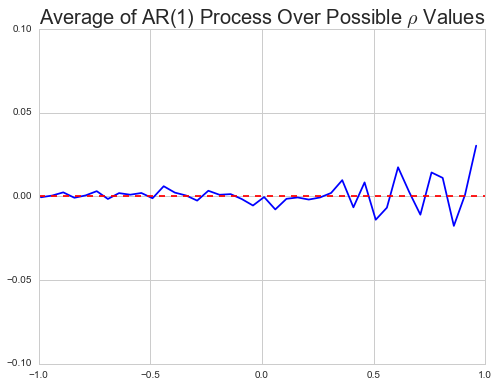

In [17]:
# Put this into context.

plt.figure(figsize = (8, 6))
plt.plot(rho, mean, 'b')
plt.title(r'Average of AR(1) Process Over Possible $\rho$ Values', fontsize=20)
plt.ylim(-.1, .1)
plt.axhline(0, color='r', ls='--')

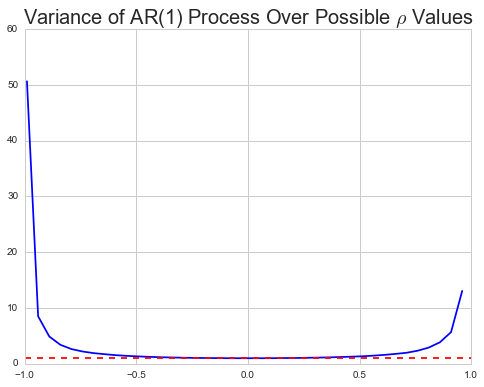

In [18]:
plt.figure(figsize = (8, 6))
plt.plot(rho, var, 'b')
plt.title(r'Variance of AR(1) Process Over Possible $\rho$ Values', fontsize=20)
plt.axhline(1, color='r', ls='--')

Therefore, we can see through MC simulation that the AR(1) process is stationary as long as $|\rho|<1$.  But let's make the point rigorous.

Eq.0: $y_t = \rho y_{t-1} + \epsilon_t$.

Eq.1: $y_{t-1} = \rho y_{t-2} + \epsilon_{t-1}$.

Eq.2: $y_{t-2} = \rho y_{t-3} + \epsilon_{t-2}$.

Substitute Eq.2 into Eq.1 to obtain $y_{t-1} = \rho^2 y_{t-3} + \rho \epsilon_{t-2} + \epsilon_{t-1}$ which is substituted into Eq.0 to obtain:

$y_{t} = \rho^3 y_{t-3} + \rho^2 \epsilon_{t-2} + \rho \epsilon_{t-1} + \epsilon_{t}$

This is the process of recursion, and the equation hints at a solution.

$\displaystyle {y_{t} = \rho^k y_{t-k} + \sum_{j=1}^k \rho^{j-1} \epsilon_{t-j+1}}$

The first term to the right of $=$ is where $y_t$ was $k$ periods ago, while the second is the sum of white noise terms.  Suppose we could go backward "infinitely" far?

$\displaystyle {\lim_{k \rightarrow \infty} \left( \rho^k y_{t-k} + \sum_{j=1}^k \rho^{j-1} \epsilon_{t-j+1}\right)}$

The first term vanishes because $|\rho|<1$.  Therefore,

$\displaystyle {y_t = \sum_{j=1}^\infty \rho^{j-1} \epsilon_{t-j+1}}$.

Therefore, $y_t$ is the infinite sum of white noise innovations that geometrically decay the further back in time an innovation occurred.  As long as the $\epsilon$'s are stationary (which we've assumed), $y_t$ is stationary.

This representation also makes calculating the mean and variance much easier.

$\displaystyle {E(y_t) = E\left(\sum_{j=1}^\infty \rho^{j-1} \epsilon_{t-j+1}\right) = \sum_{j=1}^\infty \rho^{2(j-1)} E(\epsilon_{t-j+1}) = 0}$

$\displaystyle {Var(y_t) = Var\left(\sum_{j=1}^\infty \rho^{j-1} \epsilon_{t-j+1}\right) = \sum_{j=1}^\infty \rho^{2(j-1)} Var(\epsilon_{t-j+1}) = \sum_{j=1}^\infty \rho^{2(j-1)} = \frac{1}{1-\rho^2}}$

These results can be seen in the graphs above, where the red horizontal lines are 0 and 1, respectively.  (Note the value of doing this both with MC simulation as well as with mathematics.)

$\displaystyle {Cov(y_t, y_{t-1})= E(y_t \cdot y_{t-1}) = E\left(\sum_{j=1}^\infty \rho^{j-1} \epsilon_{t-j+1} \cdot \sum_{j=1}^\infty \rho^{j-1} \epsilon_{t-j}\right)}$

This looks like a mess, but it is not.  Remember, the $\epsilon$'s are independent across time, so whenever their subscripts don't match, the expected product is zero.  We pick up a $\rho$ for the one time period when $\epsilon$ is the same, and we still have the infinite sum of $\rho^2$.  Therefore, 

$\displaystyle {Cov(y_t, y_{t-1})= E(y_t \cdot y_{t-1}) = \frac{\rho}{1-\rho^2}}$

Indeed, for any $k$,

$\displaystyle {Cov(y_t, y_{t-1})= \frac{\rho^k}{1-\rho^2}}$

More importantly, since correlation is defined as covariance divided by variance, for any AR(1) process, $y_t$, the "autocorrelation" function is simply:

$\displaystyle {Corr(y_t, y_{t-k})= \rho^k}$

Here, autocorrelation simply means "correlated with itself through time".

Therefore, in summary, the AR(1) process, $y_t$, has the following characteristics:

1. Zero mean.
2. Finite variance.
3. Autocorrelation function that decays geometrically, $\rho^k$, over $k$ periods.  Note that for $k=0$, correlation is 1 (as it should be).

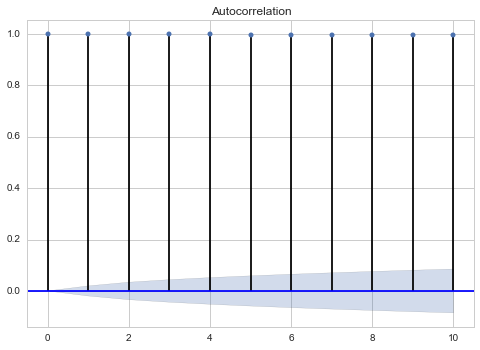

In [22]:
# Let's graph the autocorrelation function using the times series functions in StatsModels
# Remember StatsModels uses Panda's dataframes, but we generate the AR(1) using numpy arrays.
# We have to turn the numpy array into a dataframe.
# Let's toggle through a few different values of rho.

T = 9999
rho = 1
y = np.zeros(T+1)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)

y = pd.DataFrame(y)

fig = plt.figure(figsize=(10,6))
fig = sma.graphics.tsa.plot_acf(y.values.squeeze(), lags=10)

What is the utility of the autocorrelation graph?  It is a direct statistical estimate of $\rho$ if we ran a linear model that regressed $y_t$ on $y_{t-1}$.  In both Python and R, confidence bounds are placed on the graph (in blue in this case).  

## The Linkage Between AR(1) and Markov Processes: $\rho = 1$

('Variance of the process is', 25.545126997227513)


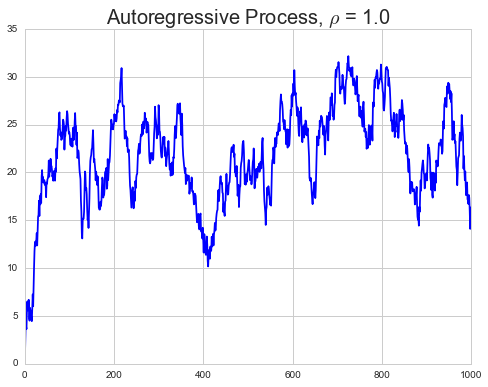

In [23]:
T = 1000
rho = 1.0
y = np.zeros(T)

y[0] = np.random.normal(0, 1)

for t in range(1, T):
    y[t] = rho * y[t-1] + np.random.normal(0, 1)

r = rho
plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)

print("Variance of the process is", np.var(y))
# Note that variance is finite in finite sample.

When $\rho \rightarrow 1$, the AR(1) model is no longer a stationary process, as the variance becomes infinite.  

Look at the equation:

$y_t = y_{t-1} + \epsilon_t$

Basically, this equation says that today is yesterday plus some white noise innovation.

Technically, the process now becomes the infinite sum of prior white noise innovations, which does not have finite variance.

$\displaystyle {y_t = \sum_{i=0}^\infty \epsilon_{t-i}}$

$\displaystyle {Var(y_t) = Var\left(\sum_{i=0}^\infty \epsilon_{t-i}\right) = \sum_{i=0}^\infty Var(\epsilon_{t-i}) = \sum_{i=0}^\infty 1}$, which does not converge.

Such processes are said to be "integrated of order 1" or I(1).  

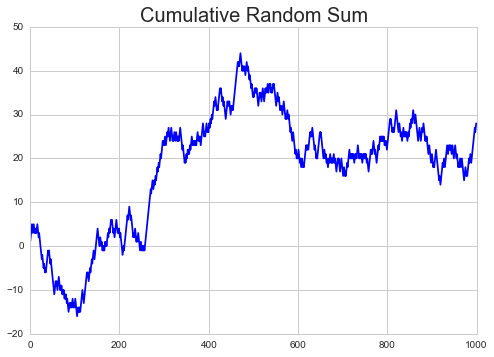

In [24]:
# Cumulative sum of random innovations.
# Basically, it is just rho = 1 in the AR(1) model.

nsteps = 1000
draws = np.random.randint(0, 2, nsteps)
steps = np.where(draws > 0, 1, -1)
walk = steps.cumsum()
plt.plot(walk, 'b')
plt.title('Cumulative Random Sum', fontsize=20)

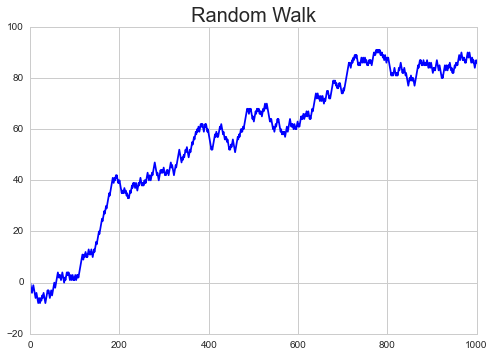

In [25]:
# Which is basically just the Markov random walk.

pos = 0  
walk = [pos] 
nsteps = 1000 
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 
    pos += step
    walk.append(pos)

plt.plot(walk, 'b')
plt.title('Random Walk', fontsize=20)

Therefore, the Markov process and the AR(1) model are intimately related.

## AR(1) Lab

Take the CAPM code you used for Homework 2 and read in five years of stock price data for the company you used for estimating the CAPM in that Homework.  Calculate the daily returns in the usual manner.  Generate an autocorrelation graph for the daily returns.  Are your daily returns autocorrelated?  (R users see the acf() command, http://www.inside-r.org/r-doc/stats/acf, which is easy to use).  Remember to drop missing observations.

Now generate measure that is the square of returns, called squared returns.  Generate a measure that is the square root of squared returns.  This is typically thought of as measure of the volatility of returns.  Periods with a larger standard deviation in returns are considered to periods with more volatility.  Generate an autocorrelation graph for volatility.  Is volatility autocorrelated?  

## Moving Average Processes of Order 1: MA(1)

There is another standard time series process, called the Moving Average of Order 1, or MA(1), process.  

$y_t = \epsilon_t + \theta \epsilon_{t-1}$

That is, the process is a weighted sum of prior white noise innovations.  Again, we can build this process from scratch.

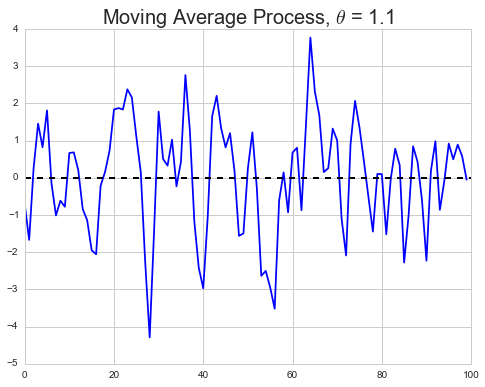

In [26]:
T = 100
theta = 1.1
y = np.zeros(T)
e = np.zeros(T)

e[0] = np.random.normal(0, 1)
y[0] = e[0]

for t in range(1, T):
    e[t] = np.random.normal(0, 1)
    y[t] = e[t] + theta * e[t-1] 
    
t = theta
plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
#plt.ylim(-4, 4)
plt.title(r'Moving Average Process, $\theta$ = %r' %(t), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

## ARMA(1, 1)

MA(1) is not that interesting.  It can, however, be combined with the AR(1) process to give rise to a model with very rich time series features.  Again, we will build from scatch.

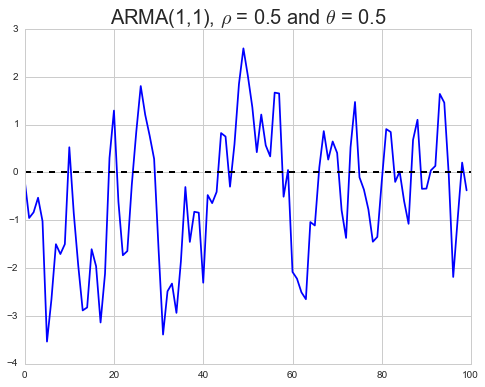

In [27]:
T = 100
theta = 0.5
rho = 0.5
y = np.zeros(T)
e = np.zeros(T)

e[0] = np.random.normal(0, 1)
y[0] = e[0]

for t in range(1, T):
    e[t] = np.random.normal(0, 1)
    y[t] = rho * y[t-1] + e[t] + theta * e[t-1] 
    
r = rho, theta
plt.figure(figsize = (8, 6))
plt.plot(y, 'b')
#plt.ylim(-4, 4)
plt.title(r'ARMA(1,1), $\rho$ = %r and $\theta$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

### Estimating an ARMA(1, 1) Statistically

In [30]:
# Stats models has an ARMA estimator.  The AR component is simple: just linear regression.
# The MA component, however, requires the use of maximum likelihood estimation.
# Always have a back-up plan.

aapl_all = Quandl.get("YAHOO/AAPL", trim_start="2010-1-1", trim_end="2015-1-1")
aapl = aapl_all['Adjusted Close']
aapl_returns = np.log(aapl / aapl.shift(1)).dropna()
aapl_returns = pd.DataFrame(aapl_returns)

arma = sma.tsa.ARMA(aapl_returns, order=(1,1)).fit()
print(arma.summary())

                              ARMA Model Results                              
Dep. Variable:         Adjusted Close   No. Observations:                 1257
Model:                     ARMA(1, 1)   Log Likelihood                3353.890
Method:                       css-mle   S.D. of innovations              0.017
Date:                Mon, 02 Nov 2015   AIC                          -6699.779
Time:                        19:33:00   BIC                          -6679.233
Sample:                    01-05-2010   HQIC                         -6692.057
                         - 12-31-2014                                         
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                    0.0011      0.000      2.184      0.029         0.000     0.002
ar.L1.Adjusted Close     0.1840      0.610      0.302      0.763        -1.011     1.379
ma.L1.Adjust

### Isolating Cycles from Trends in Time Series Data

Occasionally, we do not need to do much to time series data than to disaggregate them into two hypothetical components, a systematic trend and a noisy cycle.  A typical example is seasonality: during particular periods of time $every$ year, there is a increase or decrease in a time series (such as holiday sales) that are not necessarily of particular interest.

A popular algorithm to detrend data is the Hodrick-Prescott (HP) filter.  Basically, the filter disaggregates a time series, $y_t$, into its trend component and its cyclical component.  Our interest may lie in examining the trend rather than the noisy cycle.  

(R users, see the mFilter library: https://cran.r-project.org/web/packages/mFilter/mFilter.pdf)

In [ ]:
# Let's look at US output per person.
# First line reads in data from Quandl.
# Second line invokes Statsmodels HP filter, creating two new series, cycle and trend.

gdp_pc = Quandl.get("MWORTH/0_5", trim_start="1950-1-1", trim_end="2015-10-1")

cycle, trend = sma.tsa.filters.hpfilter(gdp_pc)

In [ ]:
# Here is a graph of the data.

plt.figure(figsize = (8,6))
gdp_pc.plot(color='blue')
plt.title('U.S. Output per Person (1950 - Present)', fontsize=20)

In [ ]:
# Cyclical component

plt.figure(figsize = (8,6))
cycle.plot(color='blue')
plt.title('Cyclical Component', fontsize=20)

In [ ]:
# Trend component.

plt.figure(figsize = (8,6))
trend.plot(color='blue')
plt.title('Trend Component', fontsize=20)

### End Thought

"There’s a further twist: once a learned program is deployed, the bad guys change their behavior to defeat it. This contrasts with the natural world, which always works the same way. The solution is to marry machine learning with game theory... "

Pedro Domingos, The Master Algorithm.